In [1]:
!pip install pyDecision

/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.2 MB/s eta 0:00:00ta 0:00:01


In [2]:
# Required Libraries
import numpy as np
import pandas as pd

from pyDecision.algorithm import electre_tri_b

In [25]:
# Load subset
df = pd.read_csv('/project/subset.csv')
df.head(3)

,Employment,Trolleybus,number of bikes,Crime Degree,Ramp // Crosswalk
0,2.0,0.0,0.0,1.5,0.666667
1,2.0,0.0,36.0,1.0,0.000000
2,2.0,0.0,30.0,1.0,0.000000


## Normalization

The direction of preference (i.e., whether higher or lower values are better) determines whether a criterion is a maximization or minimization criterion. We will align all criteria in a way such that higher values are always better, which simplifies further analysis.The minimization criteria were transformed to maximization criteria by applying a reversed scale min–max normalization. The maximization criteria were normalized using a standard min–max normalization.

Here, in the subset of the data only Crime Degree is a minimization criteria, hence we will reverse min-max normalize only that one.

In [26]:
# First, perform min-max normalization on all columns
df_normalized = (df - df.min()) / (df.max() - df.min())

# Now, reverse the scale of the minimization criteria by subtracting from 1
minimization_criteria = ['Crime Degree']  # list the minimization criteria here
df_normalized[minimization_criteria] = 1 - df_normalized[minimization_criteria]


In [27]:
df_normalized.head()

,Employment,Trolleybus,number of bikes,Crime Degree,Ramp // Crosswalk
0,0.250,0.0,0.000000,0.8,0.666667
1,0.250,0.0,1.000000,1.0,0.000000
2,0.250,0.0,0.833333,1.0,0.000000
3,0.125,0.0,0.833333,1.0,0.000000
4,0.125,0.0,0.833333,1.0,0.000000


In [28]:
# Convert to array format

arr = df_normalized.values

In [29]:
arr

array([[0.25      , 0.        , 0.        , 0.8       , 0.66666667],
       [0.25      , 0.        , 1.        , 1.        , 0.        ],
       [0.25      , 0.        , 0.83333333, 1.        , 0.        ],
       ...,
       [0.75      , 0.        , 0.70833333, 0.2       , 1.        ],
       [0.75      , 0.        , 0.70833333, 0.2       , 1.        ],
       [0.75      , 0.        , 0.70833333, 0.2       , 1.        ]])

## Set parameters for each variable

### Weight

We will give higher weights to crime and employement as they provide more valuable information on how liveable an area is.

In [30]:
W = [0.3, 0.133, 0.133, 0.3, 0.133] 

### Indifference Threshold

The indifference threshold relates to when the difference between two scores is so small that it can be ignored. For crime degree, we will have a 5% indifference threshold meaning that differences smaller than 5% are not practically significant. For the remaining variables, we will set a higher threshold at 10% as the differences for these would be less significant than crime.

In [38]:
Q = [0.1, 0.1, 0.1, 0.05, 0.1]

### Preference Threshold

The preference threshold is for when the difference between two scores is significant enough to indicate a clear preference. For the preference threshold, we will have the smallest value for crime, and then for employment. For the other variables we will have 0 as the preference threshold. We will do this, to emphasize the effect of crime and employment. If an area performs slightly better in terms of crime (0.05) it will be preferred over another area, the same will go for employment as well for 0.1.

In [37]:
P = [0.1, 0, 0, 0.05, 0]

### Veto Threshold

The veto threshold, defining when the difference between two scores is so large that it overrides all other considerations. The veto threshold is about differences between scores, not about the scores themselves. Even if the difference between two areas for Crime degree is just 0.1, we will veto the the alternative with the lower score would be considered to be significantly worse on that criterion. For employment, we will set the threshold at 0.2.

In [18]:
df_normalized['Crime Degree'].unique()

array([0.8       , 1.        , 0.        , 0.6       , 0.33333333,
       0.2       , 0.4       ])

In [23]:
df_normalized['Ramp // Crosswalk'].unique()

array([0.66666667, 0.        , 1.        , 0.5       , 0.8       ,
       0.57142857])

In [34]:
V = [0.2, 0, 0, 0.1, 0]

### Boundary Profile

We will create 3 categories, "liveable", "mildly liveable", and "not liveable". For the "not liveable" category we will have the highest threshold for Crime Degree, similarly for the second boundary profile we will have the highest threshold for Crime Degree. We set these values using the occurence of unique values in our data.

In [35]:
B1 = [0.4, 0.4, 0.3, 0.6, 0.3]
B2 = [0.6, 0.6, 0.65, 0.8, 0.6]

B = [B1, B2]  # B is a list of boundary profiles


## ELECTRE-TRI

cut_level is the credibility of the assignment to a category, ex. an alternative must have a credibility score of at least 0.75 to be assigned to a category.
we use the pessimistic criterion, which is more conservative and tends to favor assignment to the lowest possible category.

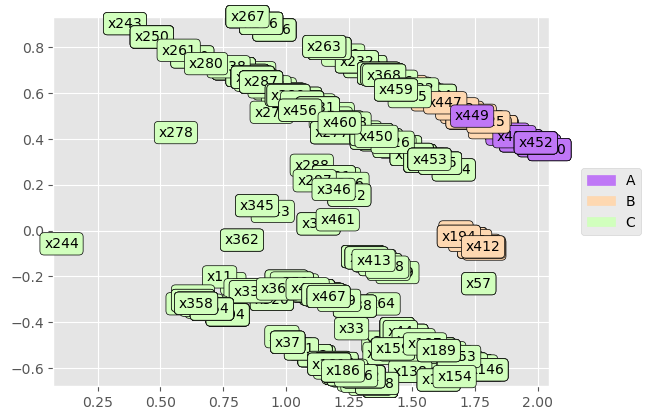

In [39]:
# Call Electre Tri-B Function
classification = electre_tri_b(arr, W , Q , P , V , B , cut_level = 0.75, verbose = False, rule = 'pc', graph = True)

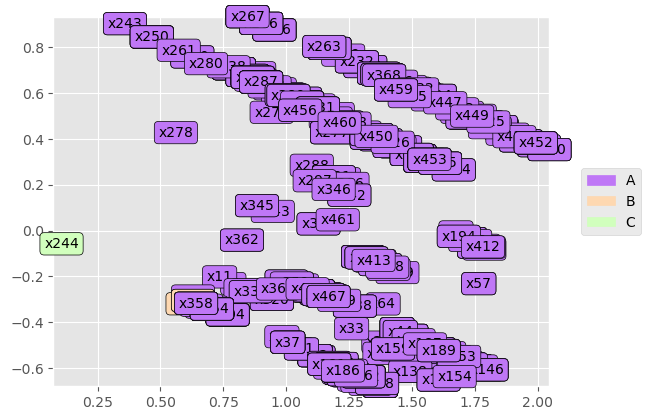

In [40]:
# if we used the optimistic criterion

# Call Electre Tri-B Function
classification = electre_tri_b(arr, W , Q , P , V , B , cut_level = 0.75, verbose = False, rule = 'oc', graph = True)